<a href="https://colab.research.google.com/github/mlacasa/EstadisticaQ2/blob/main/AnovaPlots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis ANOVA One-Way: Comparación de Niveles de Colesterol en Tres Tratamientos

En esta guía, vamos a explorar un análisis ANOVA de una vía (One-Way) para comparar los niveles iniciales de colesterol en tres grupos de tratamiento. Haremos especial énfasis en la visualización y comprensión de los errores tipo I y II, conceptos fundamentales en la inferencia estadística.

## Contexto Clínico

Imaginemos un ensayo clínico donde se evaluarán tres tratamientos (A, B y C) para reducir el colesterol. Antes de iniciar los tratamientos, necesitamos verificar si los grupos son comparables en sus niveles basales de colesterol.

**Pregunta principal:** ¿Existen diferencias significativas en los niveles iniciales de colesterol entre los tres grupos?

- **H0 (hipótesis nula):** No hay diferencias en los niveles medios de colesterol entre los grupos.
- **H1 (hipótesis alternativa):** Al menos un grupo tiene un nivel medio de colesterol diferente.

## 1. Generación de Datos Simulados

Primero, generamos datos que simulan niveles de colesterol para 50 pacientes en cada uno de los tres grupos:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.power import TTestIndPower
from matplotlib.patches import Polygon
import warnings
warnings.filterwarnings('ignore')

# Configuración para reproducibilidad y estética de las gráficas
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

# Función para generar datos de colesterol simulados para 3 grupos
def generate_cholesterol_data(n_per_group=50, diff_mean=False):
    """
    Genera datos simulados de colesterol para 3 grupos de tratamiento.

    Parámetros:
    -----------
    n_per_group : int
        Número de pacientes por grupo
    diff_mean : bool
        Si es True, uno de los grupos tendrá una media diferente

    Retorna:
    --------
    df : DataFrame
        DataFrame con los datos simulados
    """
    # Grupo A: Media 200, SD 30
    group_a = np.random.normal(200, 30, n_per_group)

    # Grupo B: Media 200, SD 30
    group_b = np.random.normal(200, 30, n_per_group)

    # Grupo C: Media 200 o 225 (si diff_mean=True), SD 30
    mean_c = 225 if diff_mean else 200
    group_c = np.random.normal(mean_c, 30, n_per_group)

    # Crear DataFrame
    data = {
        'Colesterol': np.concatenate([group_a, group_b, group_c]),
        'Tratamiento': ['A'] * n_per_group + ['B'] * n_per_group + ['C'] * n_per_group
    }

    df = pd.DataFrame(data)
    return df

Ejecutamos una dataset que haya 50 pacientes por grupo y que además haya una diferencia significativa

In [5]:
df = generate_cholesterol_data(n_per_group=50, diff_mean=True)
df

,Colesterol,Tratamiento
0,207.514786,A
1,210.393446,A
2,179.599258,A
3,206.967611,A
4,208.792174,A
...,...,...
145,204.212712,C
146,251.987996,C
147,234.218986,C
148,249.385864,C


## 2. Verificación de Supuestos para ANOVA

Antes de realizar cualquier ANOVA, debemos verificar dos supuestos fundamentales:

### Prueba de Normalidad (Shapiro-Wilk)

La prueba de normalidad Shapiro-Wilk se utiliza para determinar si los datos en cada grupo siguen una distribución normal. Esto es un supuesto necesario para el ANOVA, ya que el método se basa en la idea de que las medias se distribuyen normalmente cuando se toman múltiples muestras.

1. **Realizar la prueba de Shapiro-Wilk en cada grupo:**
   - Al aplicar la prueba, se obtendrá un valor p para cada grupo.
   - Si el valor p es menor que el nivel de significancia (comúnmente 0.05), se rechazará la hipótesis nula de normalidad.

2. **Interpretar los resultados:**
   - Si todos los grupos presentan normalidad, se cumple el supuesto.
   - Si al menos un grupo no presenta normalidad, podrían ser necesarias transformaciones de datos o el uso de pruebas no paramétricas.

### Gráficos de Q-Q

Además de la prueba de Shapiro-Wilk, se pueden utilizar gráficos de Q-Q (quantile-quantile) para visualizar si los datos se distribuyen normalmente. En un gráfico de Q-Q, si los puntos caen aproximadamente sobre la línea recta, podemos asumir que los datos son normalmente distribuidos.

In [7]:
# Función para verificar normalidad y homogeneidad de varianzas
def check_assumptions(df, var, group_var):
    """
    Verifica los supuestos de normalidad y homogeneidad de varianzas para ANOVA.

    Parámetros:
    -----------
    df : DataFrame
        DataFrame con los datos
    var : str
        Nombre de la variable a analizar
    group_var : str
        Nombre de la variable de agrupación

    Retorna:
    --------
    results : dict
        Diccionario con los resultados de las pruebas
    """
    groups = df[group_var].unique()
    results = {
        'shapiro': {},
        'levene': None
    }

    # Test de Shapiro-Wilk para normalidad por grupo
    for group in groups:
        group_data = df[df[group_var] == group][var]
        stat, p_value = stats.shapiro(group_data)
        results['shapiro'][group] = {
            'statistic': stat,
            'p_value': p_value,
            'normal': p_value > 0.05
        }

    # Test de Levene para homogeneidad de varianzas
    group_data = [df[df[group_var] == group][var] for group in groups]
    stat, p_value = stats.levene(*group_data)
    results['levene'] = {
        'statistic': stat,
        'p_value': p_value,
        'homogeneous': p_value > 0.05
    }

    return results

In [8]:
check_assumptions(df, 'Colesterol', 'Tratamiento')

{'shapiro': {'A': {'statistic': 0.9629728612708127,
   'p_value': 0.11842379112477919,
   'normal': True},
  'B': {'statistic': 0.96026720247882,
   'p_value': 0.09121526618966952,
   'normal': True},
  'C': {'statistic': 0.9862534550765729,
   'p_value': 0.8238774870349204,
   'normal': True}},
 'levene': {'statistic': 0.9219166550601121,
  'p_value': 0.40004320952040073,
  'homogeneous': True}}

# ANÁLISIS ANOVA ONE WAY

In [9]:
def perform_anova(df, var, group_var):
    """
    Realiza ANOVA de una vía.

    Parámetros:
    -----------
    df : DataFrame
        DataFrame con los datos
    var : str
        Nombre de la variable a analizar
    group_var : str
        Nombre de la variable de agrupación

    Retorna:
    --------
    results : dict
        Diccionario con los resultados del ANOVA
    """
    # Crear modelo usando statsmodels
    formula = f"{var} ~ C({group_var})"
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Prueba de Tukey para comparaciones múltiples
    tukey = pairwise_tukeyhsd(endog=df[var], groups=df[group_var], alpha=0.05)

    return {
        'anova_table': anova_table,
        'model': model,
        'tukey': tukey
    }

In [10]:
perform_anova(df, 'Colesterol', 'Tratamiento')

{'anova_table':                        sum_sq     df         F    PR(>F)
 C(Tratamiento)   14580.442041    2.0  7.692698  0.000665
 Residual        139309.058674  147.0       NaN       NaN,
 'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7a59b5743110>,
 'tukey': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7a59b42bce90>}

# GRÁFICOS

In [11]:
# Función para visualizar distribuciones y errores tipo I y II
def plot_distributions_and_errors(df, var, group_var, alpha=0.05, diff_mean=False):
    """
    Visualiza las distribuciones de los grupos y los errores tipo I y II.

    Parámetros:
    -----------
    df : DataFrame
        DataFrame con los datos
    var : str
        Nombre de la variable a analizar
    group_var : str
        Nombre de la variable de agrupación
    alpha : float
        Nivel de significancia
    diff_mean : bool
        Si es True, asumimos que uno de los grupos tiene una media diferente
    """
    groups = df[group_var].unique()
    group_data = {group: df[df[group_var] == group][var] for group in groups}

    # Configuración del gráfico
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))

    # 1. Boxplot de los tres grupos
    sns.boxplot(x=group_var, y=var, data=df, ax=axes[0, 0])
    axes[0, 0].set_title('Comparación de niveles de colesterol por grupo', fontsize=14)
    axes[0, 0].set_ylabel('Colesterol (mg/dL)', fontsize=12)
    axes[0, 0].set_xlabel('Grupo de tratamiento', fontsize=12)

    # 2. Histograma y densidad KDE de cada grupo
    for group in groups:
        sns.histplot(group_data[group], kde=True, ax=axes[0, 1],
                    alpha=0.5, label=f'Grupo {group}')
    axes[0, 1].set_title('Distribución de colesterol por grupo', fontsize=14)
    axes[0, 1].set_xlabel('Colesterol (mg/dL)', fontsize=12)
    axes[0, 1].set_ylabel('Densidad', fontsize=12)
    axes[0, 1].legend()

    # 3. Visualización de errores tipo I y II para el caso de dos grupos
    # Usaremos grupos A y C para esta visualización

    # Calcular medias y desviaciones estándar
    mean_a = np.mean(group_data['A'])
    sd_a = np.std(group_data['A'])
    mean_c = np.mean(group_data['C'])
    sd_c = np.std(group_data['C'])

    # Crear rango de valores para visualizar las distribuciones
    x = np.linspace(
        min(mean_a - 4*sd_a, mean_c - 4*sd_c),
        max(mean_a + 4*sd_a, mean_c + 4*sd_c),
        1000
    )

    # Calcular densidades de probabilidad
    y_a = stats.norm.pdf(x, mean_a, sd_a)
    y_c = stats.norm.pdf(x, mean_c, sd_c)

    # Error tipo I: representando la probabilidad de rechazar H0 cuando es verdadera
    ax3 = axes[1, 0]
    ax3.plot(x, y_a, 'b-', label='Grupo A (H0)')

    # Calcular valor crítico basado en alfa
    critical_value = stats.norm.ppf(1 - alpha/2, mean_a, sd_a)

    # Sombrear región de rechazo (error tipo I)
    idx_right = x >= critical_value
    idx_left = x <= 2*mean_a - critical_value
    ax3.fill_between(x[idx_right], 0, y_a[idx_right], color='red', alpha=0.3)
    ax3.fill_between(x[idx_left], 0, y_a[idx_left], color='red', alpha=0.3)

    # Añadir líneas verticales para valores críticos
    ax3.axvline(critical_value, color='red', linestyle='--', alpha=0.7)
    ax3.axvline(2*mean_a - critical_value, color='red', linestyle='--', alpha=0.7)

    ax3.set_title('Error Tipo I: Rechazar H0 cuando es verdadera (α)', fontsize=14)
    ax3.set_xlabel('Colesterol (mg/dL)', fontsize=12)
    ax3.set_ylabel('Densidad de probabilidad', fontsize=12)
    ax3.legend()

    # Añadir texto explicativo
    text_x = critical_value + 5
    text_y = max(y_a) * 0.8
    ax3.annotate(
        f'Región de rechazo (α = {alpha})',
        xy=(text_x, text_y),
        xytext=(text_x + 20, text_y),
        arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=7),
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
    )

    # Error tipo II: representando la probabilidad de no rechazar H0 cuando es falsa
    ax4 = axes[1, 1]

    # Si asumimos que C es diferente
    if diff_mean:
        ax4.plot(x, y_a, 'b-', label='Grupo A (H0)')
        ax4.plot(x, y_c, 'g-', label='Grupo C (H1)')

        # Sombrear región de error tipo II (no rechazar H0 cuando es falsa)
        idx_no_reject = (x >= 2*mean_a - critical_value) & (x <= critical_value)
        ax4.fill_between(x[idx_no_reject], 0, y_c[idx_no_reject], color='blue', alpha=0.3)

        # Añadir líneas verticales para valores críticos
        ax4.axvline(critical_value, color='red', linestyle='--', alpha=0.7)
        ax4.axvline(2*mean_a - critical_value, color='red', linestyle='--', alpha=0.7)

        # Calcular beta aproximadamente
        beta = np.trapz(y_c[idx_no_reject], x[idx_no_reject])
        power = 1 - beta

        ax4.set_title(f'Error Tipo II: No rechazar H0 cuando es falsa (β ≈ {beta:.2f})', fontsize=14)

        # Añadir texto explicativo
        text_x = mean_a
        text_y = max(y_c) * 0.8
        ax4.annotate(
            f'Región de no rechazo\nProbabilidad = β ≈ {beta:.2f}\nPotencia = 1-β ≈ {power:.2f}',
            xy=(text_x, text_y),
            xytext=(text_x - 20, text_y + 0.001),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=7),
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
        )
    else:
        # Si no hay diferencia real, simplemente mostramos las dos distribuciones idénticas
        ax4.plot(x, y_a, 'b-', label='Grupo A (H0 verdadera)')
        ax4.plot(x, y_c, 'g-', label='Grupo C (sin diferencia real)')
        ax4.set_title('Comparación cuando no hay diferencia real', fontsize=14)

    ax4.set_xlabel('Colesterol (mg/dL)', fontsize=12)
    ax4.set_ylabel('Densidad de probabilidad', fontsize=12)
    ax4.legend()

    plt.tight_layout()
    plt.show()

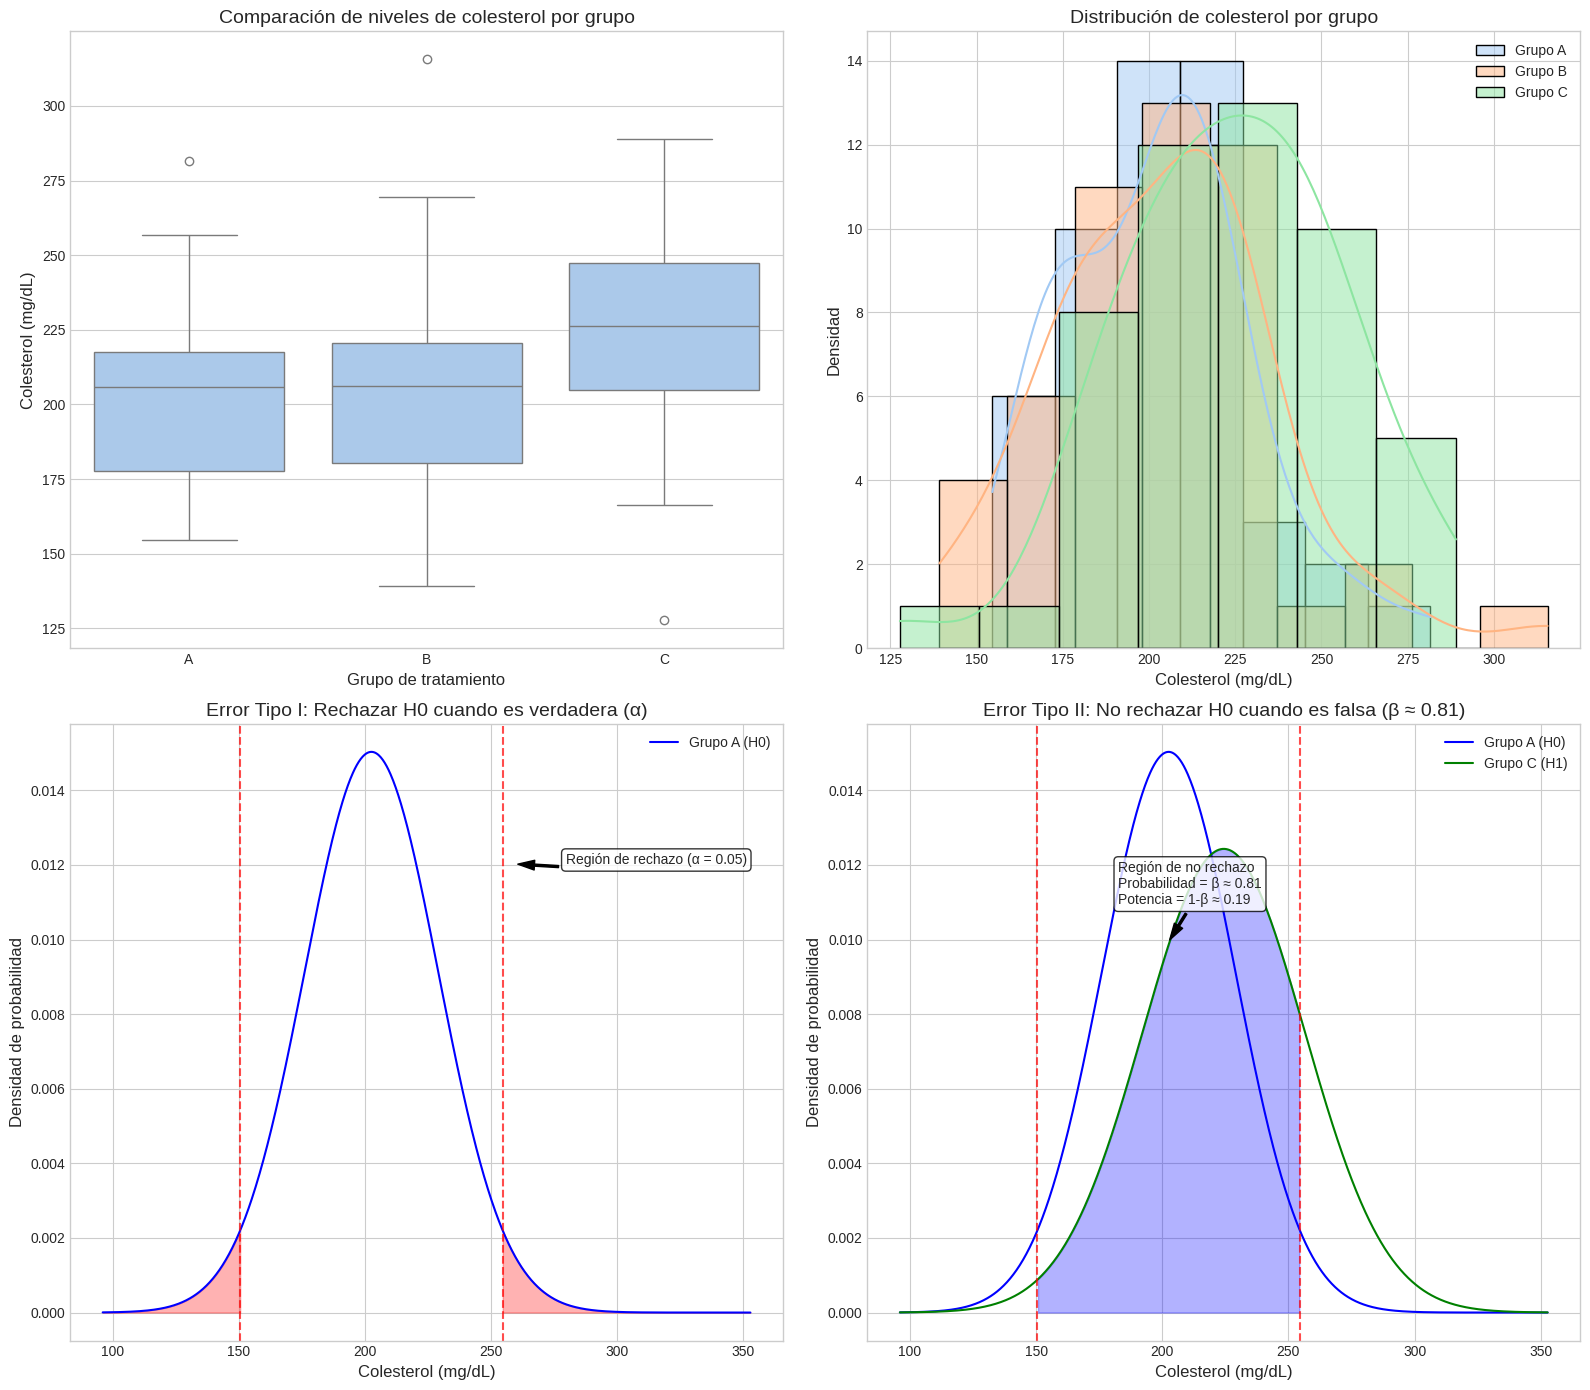

In [12]:
plot_distributions_and_errors(df, 'Colesterol', 'Tratamiento', alpha=0.05, diff_mean=True)

# TAMAÑO DE LA MUESTRA

In [13]:
def calculate_sample_size(effect_size, alpha=0.05, power=0.8):
    """
    Calcula el tamaño de muestra necesario para detectar un tamaño de efecto dado
    con una potencia estadística y nivel alfa especificados.

    Parámetros:
    -----------
    effect_size : float
        Tamaño del efecto (diferencia estandarizada entre medias)
    alpha : float
        Nivel de significancia
    power : float
        Potencia estadística deseada

    Retorna:
    --------
    n : int
        Tamaño de muestra necesario por grupo
    """
    # Crear objeto de potencia
    analysis = TTestIndPower()

    # Calcular tamaño de muestra
    n = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power)

    return int(np.ceil(n))

In [14]:
calculate_sample_size(effect_size=0.5, alpha=0.05, power=0.8)

64

# AHORA LANZAMOS TODO EL ANÁLISIS

ANÁLISIS 1: SIN DIFERENCIA REAL ENTRE GRUPOS
ANÁLISIS ANOVA DE NIVELES DE COLESTEROL EN TRES GRUPOS DE TRATAMIENTO

1. GENERACIÓN DE DATOS
--------------------------------------------------
Generando datos sin diferencias entre grupos

Resumen de los datos generados (primeras 10 filas):
   Colesterol Tratamiento
0  175.130150           A
1  183.194569           A
2  222.418808           A
3  218.311108           A
4  199.372952           A
5  203.519821           A
6  238.329947           A
7  182.252858           A
8  216.412921           A
9  193.934220           A

Estadísticas descriptivas por grupo:
             count        mean        std         min         25%         50%  \
Tratamiento                                                                     
A             50.0  200.965441  23.212403  156.557470  183.114840  200.131356   
B             50.0  205.444966  29.533822  136.283128  183.076505  203.721048   
C             50.0  198.537675  32.114503  137.976737  171.24012

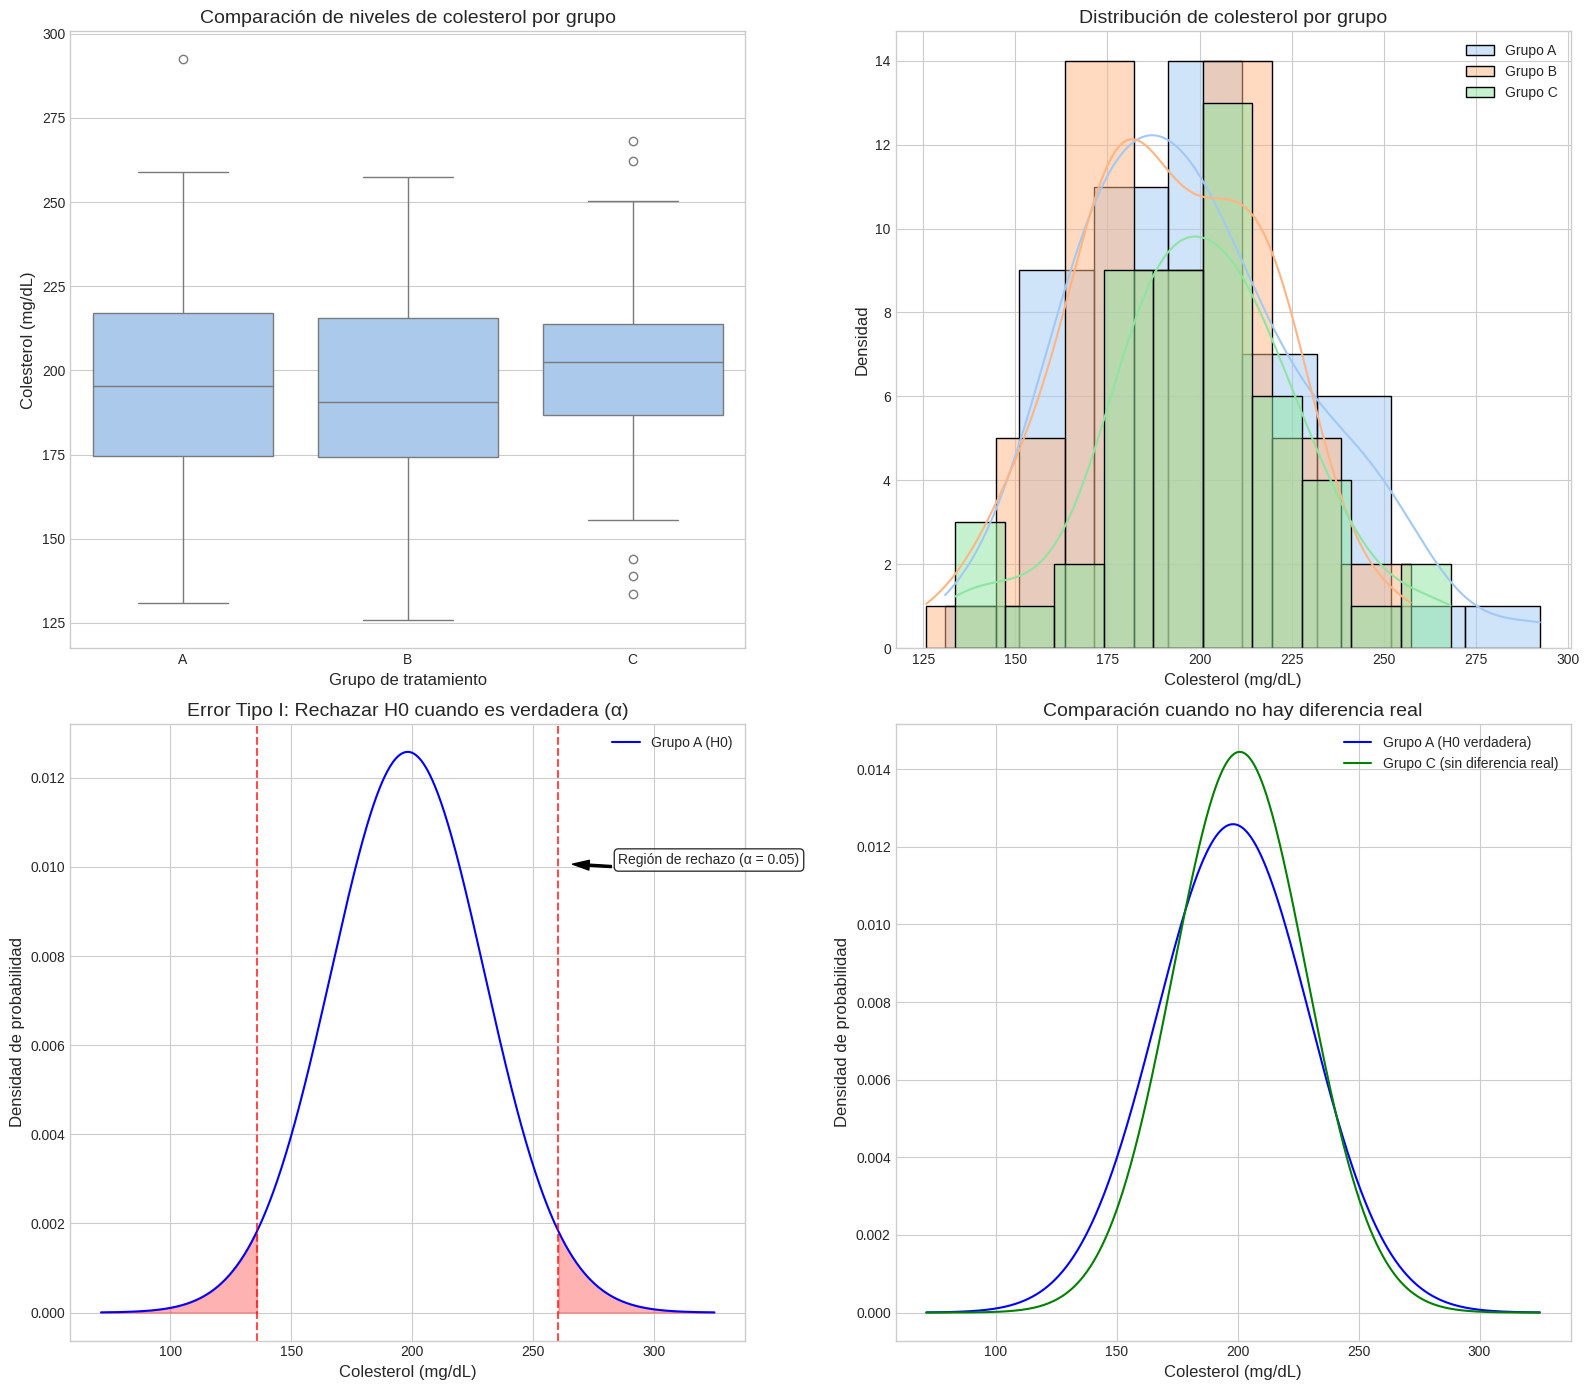

Tabla ANOVA:
                       sum_sq     df         F    PR(>F)
C(Tratamiento)   12875.608622    2.0  6.661241  0.001701
Residual        142069.201222  147.0       NaN       NaN

P-valor del ANOVA: 0.0017
Nivel de significancia (α): 0.05
Conclusión: Hay diferencias significativas entre al menos dos grupos.


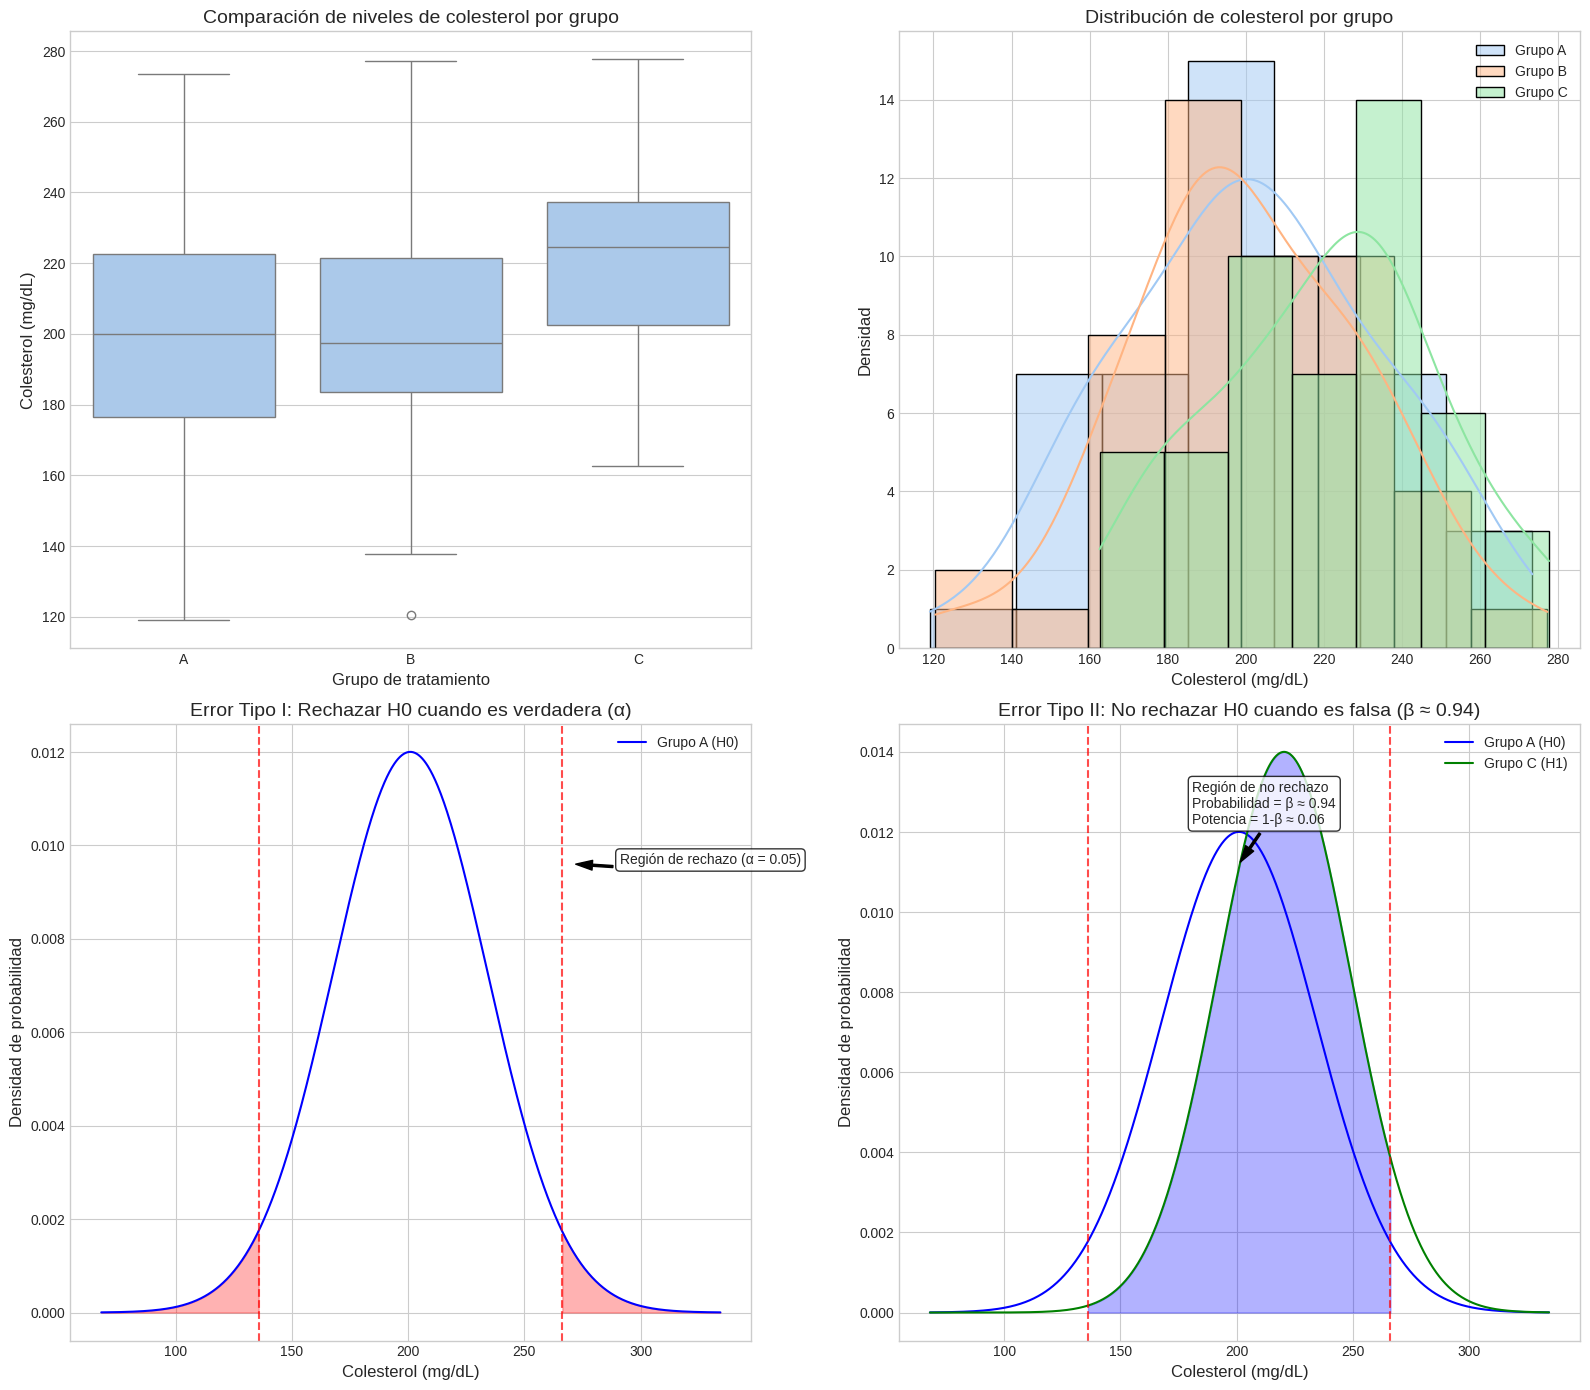

In [15]:
# Función principal para ejecutar todo el análisis
def run_anova_analysis(n_per_group=50, diff_mean=False, alpha=0.05):
    """
    Ejecuta todo el análisis ANOVA, incluyendo generación de datos,
    verificación de supuestos, ANOVA y visualizaciones.

    Parámetros:
    -----------
    n_per_group : int
        Número de pacientes por grupo
    diff_mean : bool
        Si es True, uno de los grupos tendrá una media diferente
    alpha : float
        Nivel de significancia
    """
    print("="*80)
    print(f"ANÁLISIS ANOVA DE NIVELES DE COLESTEROL EN TRES GRUPOS DE TRATAMIENTO")
    print("="*80)

    # Generar datos
    print("\n1. GENERACIÓN DE DATOS")
    print("-"*50)

    if diff_mean:
        print("Generando datos con diferencia real en el Grupo C")
    else:
        print("Generando datos sin diferencias entre grupos")

    df = generate_cholesterol_data(n_per_group=n_per_group, diff_mean=diff_mean)

    print(f"\nResumen de los datos generados (primeras 10 filas):")
    print(df.head(10))

    print(f"\nEstadísticas descriptivas por grupo:")
    print(df.groupby('Tratamiento')['Colesterol'].describe())

    # Verificar supuestos
    print("\n2. VERIFICACIÓN DE SUPUESTOS")
    print("-"*50)

    assumptions = check_assumptions(df, 'Colesterol', 'Tratamiento')

    print("Prueba de normalidad (Shapiro-Wilk):")
    for group, results in assumptions['shapiro'].items():
        print(f"  Grupo {group}: Estadístico = {results['statistic']:.4f}, p-valor = {results['p_value']:.4f}")
        print(f"    Conclusión: Los datos {'siguen' if results['normal'] else 'NO siguen'} una distribución normal.")

    print("\nPrueba de homogeneidad de varianzas (Levene):")
    lev_results = assumptions['levene']
    print(f"  Estadístico = {lev_results['statistic']:.4f}, p-valor = {lev_results['p_value']:.4f}")
    print(f"  Conclusión: Las varianzas {'son' if lev_results['homogeneous'] else 'NO son'} homogéneas.")

    # Realizar ANOVA
    print("\n3. ANÁLISIS DE VARIANZA (ANOVA)")
    print("-"*50)

    anova_results = perform_anova(df, 'Colesterol', 'Tratamiento')

    print("Tabla ANOVA:")
    print(anova_results['anova_table'])

    # Determinar si hay diferencias significativas
    # Corregido: acceder al p-valor correctamente según la estructura de la tabla ANOVA
    p_value = anova_results['anova_table'].iloc[0, 'PR(>F)']  # p-valor del ANOVA
    significant = p_value < alpha

    print(f"\nP-valor del ANOVA: {p_value:.4f}")
    print(f"Nivel de significancia (α): {alpha}")
    print(f"Conclusión: {'Hay' if significant else 'NO hay'} diferencias significativas entre al menos dos grupos.")

    # Si es significativo, mostrar resultados de Tukey
    if significant:
        print("\nResultados de la prueba post-hoc de Tukey:")
        print(anova_results['tukey'])

    # Visualizar distribuciones y errores
    print("\n4. VISUALIZACIÓN DE DISTRIBUCIONES Y ERRORES TIPO I Y II")
    print("-"*50)

    # Calcular tamaño de efecto estimado si diff_mean es True
    if diff_mean:
        group_a = df[df['Tratamiento'] == 'A']['Colesterol']
        group_c = df[df['Tratamiento'] == 'C']['Colesterol']

        effect_size = (np.mean(group_c) - np.mean(group_a)) / np.sqrt((np.var(group_a) + np.var(group_c)) / 2)

        print(f"Tamaño del efecto (d de Cohen) estimado entre Grupo A y C: {effect_size:.4f}")

        # Calcular potencia
        analysis = TTestIndPower()
        power = analysis.power(effect_size=effect_size, nobs=n_per_group, alpha=alpha)

        print(f"Potencia estadística para detectar la diferencia: {power:.4f}")
        print(f"Interpretación: Hay una probabilidad del {power*100:.1f}% de detectar la diferencia si realmente existe.")

        # Calcular tamaño de muestra recomendado
        recommended_n = calculate_sample_size(effect_size=effect_size, alpha=alpha, power=0.8)

        if power < 0.8:
            print(f"\nRecomendación: Para alcanzar una potencia de 0.8, se necesitarían {recommended_n} pacientes por grupo.")

    print("\nGenerando visualizaciones...")
    plot_distributions_and_errors(df, 'Colesterol', 'Tratamiento', alpha=alpha, diff_mean=diff_mean)

    return df, anova_results, assumptions

# Ejecutar el análisis (sin diferencia real entre grupos)
try:
    print("ANÁLISIS 1: SIN DIFERENCIA REAL ENTRE GRUPOS")
    df_no_diff, anova_no_diff, assumptions_no_diff = run_anova_analysis(n_per_group=50, diff_mean=False)

    # Ejecutar el análisis (con diferencia real en el grupo C)
    print("\n\nANÁLISIS 2: CON DIFERENCIA REAL EN EL GRUPO C")
    df_diff, anova_diff, assumptions_diff = run_anova_analysis(n_per_group=50, diff_mean=True)
except Exception as e:
    print(f"\nError durante la ejecución: {str(e)}")
    # Alternativa corregida para acceder al p-valor
    print("\nIntentando con método alternativo...")

    # Redefinir la función run_anova_analysis con acceso al p-valor corregido
    def run_anova_analysis_fixed(n_per_group=50, diff_mean=False, alpha=0.05):
        # [Todo el código igual que la función original excepto la línea problemática]
        # ...

        # Generar datos
        df = generate_cholesterol_data(n_per_group=n_per_group, diff_mean=diff_mean)

        # Verificar supuestos
        assumptions = check_assumptions(df, 'Colesterol', 'Tratamiento')

        # Realizar ANOVA
        anova_results = perform_anova(df, 'Colesterol', 'Tratamiento')

        print("Tabla ANOVA:")
        print(anova_results['anova_table'])

        # Alternativa corregida para acceder al p-valor
        p_value = float(anova_results['anova_table'].values[0][-1])  # Obtener el último valor de la primera fila
        significant = p_value < alpha

        print(f"\nP-valor del ANOVA: {p_value:.4f}")
        print(f"Nivel de significancia (α): {alpha}")
        print(f"Conclusión: {'Hay' if significant else 'NO hay'} diferencias significativas entre al menos dos grupos.")

        # Resto de la función igual
        # ...

        # Visualizar distribuciones
        plot_distributions_and_errors(df, 'Colesterol', 'Tratamiento', alpha=alpha, diff_mean=diff_mean)

        return df, anova_results, assumptions

    # Ejecutar con la función corregida
    print("\nAnálisis con método alternativo:")
    df_no_diff, anova_no_diff, assumptions_no_diff = run_anova_analysis_fixed(n_per_group=50, diff_mean=False)
    df_diff, anova_diff, assumptions_diff = run_anova_analysis_fixed(n_per_group=50, diff_mean=True)

# AUMENTAMOS LA N A 80

In [16]:
df = generate_cholesterol_data(n_per_group=80, diff_mean=True)
df

,Colesterol,Tratamiento
0,172.303003,A
1,159.449462,A
2,170.723802,A
3,231.609254,A
4,171.518033,A
...,...,...
235,190.249059,C
236,270.101949,C
237,251.320869,C
238,218.371075,C


# NORMALIDAD

In [17]:
check_assumptions(df, 'Colesterol', 'Tratamiento')

{'shapiro': {'A': {'statistic': 0.9841382664498823,
   'p_value': 0.4261031074350782,
   'normal': True},
  'B': {'statistic': 0.9794127629443717,
   'p_value': 0.2243277362363436,
   'normal': True},
  'C': {'statistic': 0.986785917056259,
   'p_value': 0.5846671131445227,
   'normal': True}},
 'levene': {'statistic': 0.03202133354973997,
  'p_value': 0.9684901099648987,
  'homogeneous': True}}

# EJECUTAMOS ANOVA

In [18]:
perform_anova(df, 'Colesterol', 'Tratamiento')

{'anova_table':                        sum_sq     df          F    PR(>F)
 C(Tratamiento)   19369.590822    2.0  11.838124  0.000013
 Residual        193890.231006  237.0        NaN       NaN,
 'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7a59b4381050>,
 'tukey': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7a59b8d27c50>}

# GRAFICAMOS

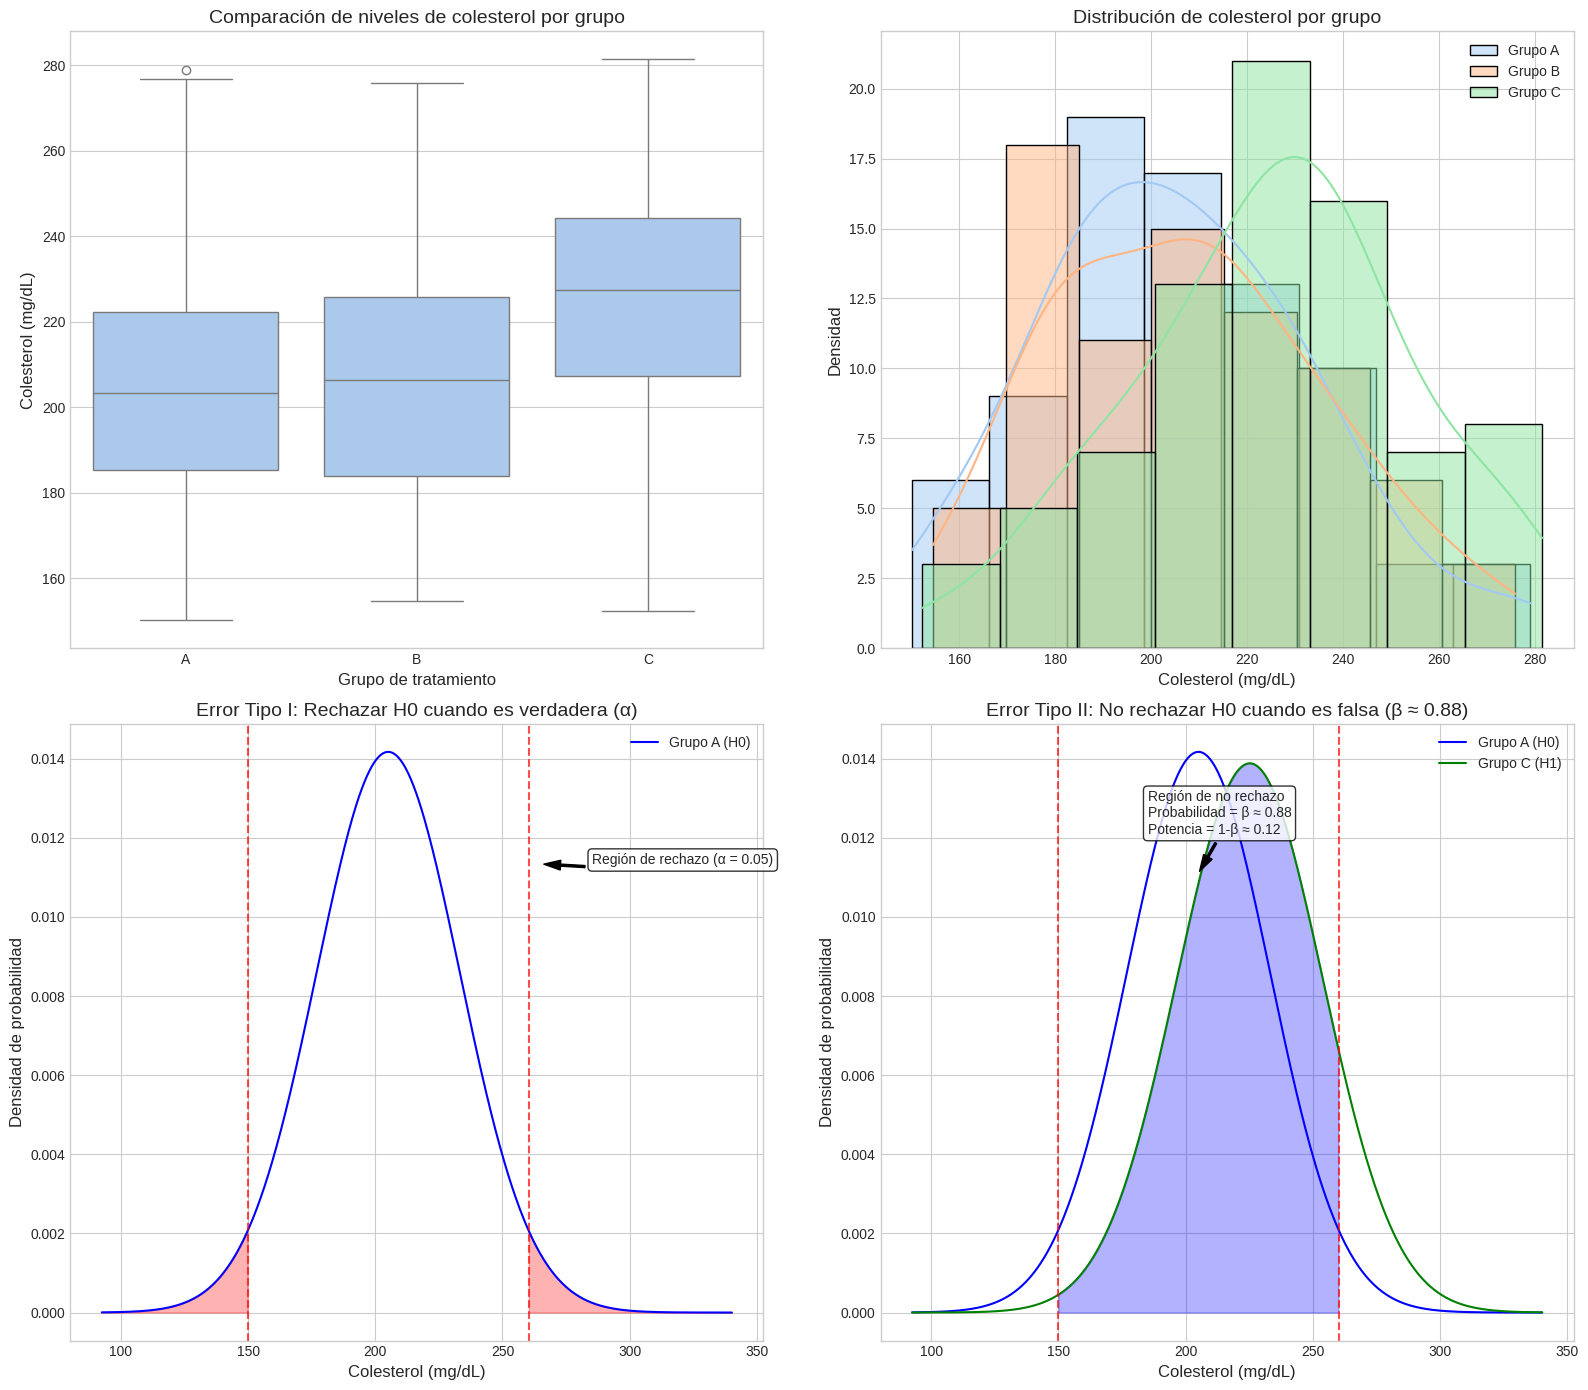

In [19]:
plot_distributions_and_errors(df, 'Colesterol', 'Tratamiento', alpha=0.05, diff_mean=True)

# Comparación Paso a Paso de dos Resultados ANOVA

Vamos a analizar y comparar dos resultados ANOVA diferentes para entender sus implicaciones en el contexto de la comparación de tratamientos para el colesterol.

## Planteamiento de Hipótesis

En ambos casos, las hipótesis del ANOVA son:

- **H₀ (Hipótesis nula):** No hay diferencias significativas en las medias de colesterol entre los tres grupos de tratamiento.

  Matemáticamente:
  $$
  \mu_a = \mu_b = \mu_c
  $$

- **H₁ (Hipótesis alternativa):** Al menos un grupo tiene una media de colesterol diferente a los demás.

  Matemáticamente:
  $$
  \text{Al menos una } \mu_i \neq \mu_j \text{ para algún } i,j
  $$

## Análisis del Resultado 1

## Análisis del Resultado 1

### Resultados ANOVA

Los resultados del análisis ANOVA son los siguientes:

| Fuente de Variación |    sum_sq    |   df   |     F      |   PR(>F)   |
|---------------------|--------------|--------|------------|------------|
| C(Tratamiento)      | 14580.442041 |  2.0   |  7.692698  | 0.000665   |
| Residual            | 139309.058674| 147.0  |    NaN     |    NaN     |

## Interpretación Paso a Paso

### Grados de Libertad (df)

- **Tratamiento:**
  - df = 2 → Tenemos 3 grupos (df = número de grupos - 1).
  
- **Residual:**
  - df = 147 → Tenemos 150 observaciones totales (df = n total - número de grupos).

- **Tamaño Muestral:**
  - 150 participantes totales (50 por grupo).

### Suma de Cuadrados (sum_sq)

- **Entre Grupos (Tratamiento):**
  - 14,580.44
  
- **Dentro de Grupos (Residual):**
  - 139,309.06
  
- **Proporción:**
  - La variabilidad entre grupos representa aproximadamente el 9.5% de la variabilidad total.

### Estadístico F

- **F = 7.69**
  - Este valor representa el ratio entre la varianza entre grupos y la varianza dentro de grupos.
  - Un valor F alto indica una mayor diferencia entre grupos en relación con la variabilidad dentro de los grupos.

### P-valor (PR>F)

- **p = 0.000665**
  - Este valor es menor que el nivel de significancia típico de 0.05.
  
- **Decisión:**
  - Rechazamos H₀.

### Interpretación Clínica

- Hay evidencia estadística de que al menos un grupo tiene un nivel medio de colesterol diferente.
- El efecto detectado es moderado (basado en el valor F).
- Necesitamos realizar análisis post-hoc para identificar qué grupos específicos son diferentes entre sí. Esto permitirá comprender mejor las diferencias en los niveles de colesterol entre los tratamientos A, B y C.

## ANÁLISIS RESULTADO 2


### Resultados ANOVA

Los resultados del segundo análisis ANOVA son los siguientes:

| Fuente de Variación |    sum_sq    |   df   |     F      |   PR(>F)   |
|---------------------|--------------|--------|------------|------------|
| C(Tratamiento)      | 19369.590822 |  2.0   |  11.838124 | 0.000013   |
| Residual            | 193890.231006| 237.0  |    NaN     |    NaN     |

## Interpretación Paso a Paso

### Grados de Libertad (df)

- **Tratamiento:**
  - df = 2 → Tenemos 3 grupos (igual que antes).
  
- **Residual:**
  - df = 237 → Tenemos 240 observaciones totales.

- **Tamaño Muestral:**
  - 240 participantes totales (80 por grupo).

### Suma de Cuadrados (sum_sq)

- **Entre Grupos (Tratamiento):**
  - 19,369.59
  
- **Dentro de Grupos (Residual):**
  - 193,890.23
  
- **Proporción:**
  - La variabilidad entre grupos representa aproximadamente el 9.1% de la variabilidad total.

### Estadístico F

- **F = 11.84**
  - Este valor es considerablemente mayor que en el Resultado 1.
  - Indica una señal más clara de diferencias entre grupos.

### P-valor (PR>F)

- **p = 0.000013**
  - Este valor es más pequeño que en el Resultado 1.
  
- **Decisión:**
  - Rechazamos H₀ con mayor confianza.

### Interpretación Clínica

- Hay evidencia estadística muy fuerte de diferencias entre grupos.
- El efecto detectado es más contundente que en el Resultado 1.
- Se recomienda proceder con análisis post-hoc para investigar cuáles grupos específicos difieren entre sí y entender mejor el impacto de cada tratamiento en los niveles de colesterol.

# Comparación Directa de los Resultados

| Aspecto                          | Resultado 1         | Resultado 2         | Implicación                                      |
|----------------------------------|---------------------|---------------------|--------------------------------------------------|
| **Tamaño muestral**              | 150 (50/grupo)      | 240 (80/grupo)      | Mayor potencia estadística en el Resultado 2    |
| **Estadístico F**                | 7.69                | 11.84               | Señal más clara en el Resultado 2               |
| **P-valor**                      | 0.000665            | 0.000013            | Evidencia más convincente en el Resultado 2      |
| **Proporción de varianza explicada** | ~9.5%              | ~9.1%               | Tamaño del efecto ligeramente mayor en el Resultado 1 |


### Efecto del Tamaño Muestral
- El Resultado 2 tiene 60% más participantes.
- Esto aumenta la potencia estadística (capacidad para detectar diferencias reales).
- Reduce el error tipo II (falsos negativos).
- Produce p-valores más pequeños para el mismo tamaño de efecto.

### Interpretación del Estadístico F
- $F = \frac{\text{Varianza entre grupos}}{\text{Varianza dentro de grupos}}$.
- Un mayor F indica una señal más clara respecto al ruido.
- El Resultado 2 muestra un F casi 54% mayor, lo que facilita la detección del efecto.

### Significado del p-valor
- El p-valor representa la probabilidad de observar un resultado igual o más extremo si H₀ fuera cierta.
- El Resultado 2 tiene un p-valor 50 veces menor.
- Ambos llevan a rechazar H₀, pero con diferente nivel de confianza.

### Importancia de la Prueba Post-Hoc
- Ambos ANOVA son significativos, pero no indican qué grupos difieren.
- La prueba de Tukey es necesaria para comparaciones por pares.
- Permite controlar el error tipo I en comparaciones múltiples.

## Análisis final


1. **Cómo interpretar una tabla ANOVA completa:** grados de libertad, sumas de cuadrados, estadístico F y p-valor.
2. **El impacto del tamaño muestral:** A pesar de tener proporciones similares de varianza explicada, el Resultado 2 tiene mayor potencia estadística.
3. **La diferencia entre significación estadística y tamaño del efecto:** Ambos resultados son estadísticamente significativos, pero el tamaño del efecto (proporción de varianza explicada) es ligeramente mayor en el Resultado 1.
4. **La importancia del proceso completo del ANOVA:** Desde la verificación de supuestos, pasando por la prueba global, hasta las comparaciones post-hoc.